## Milestone 1
### Author: Emily McAfee
#### Faulty product identification

In [30]:
# Import packages
# Data cleaning/exploration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Smote
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


# RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Forward feature selection
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# LASSO & ridge regression
from sklearn import linear_model

## 1. Read and merge data

In [2]:
# Load in data
filename = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secomdf = pd.read_csv(filename, sep = " ", header = None)

In [3]:
# Load in labels
filename2 = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secomlabels = pd.read_csv(filename2, sep = " ", header = None)

In [4]:
# Check data
secomdf.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [5]:
# Check labels
secomlabels.head()

,0,1
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [6]:
# Work with labels data
# Rename label columns
secomlabels.columns = ['class', 'datetime']

# Check data
secomlabels.head()

,class,datetime
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [7]:
# Bring together both original dataframe and labels dataframe
newdf = pd.concat([secomdf, secomlabels], axis = 1)

#Check new df
print(newdf.dtypes)
print(newdf.head())

0           float64
1           float64
2           float64
3           float64
4           float64
             ...   
587         float64
588         float64
589         float64
class         int64
datetime     object
Length: 592, dtype: object
         0        1          2          3       4      5         6       7  \
0  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   97.6133  0.1242   
1  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0  102.3433  0.1247   
2  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   95.4878  0.1241   
3  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0  104.2367  0.1217   
4  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0  100.3967  0.1235   

        8       9  ...     582     583     584      585     586     587  \
0  1.5005  0.0162  ...  0.5005  0.0118  0.0035   2.3630     NaN     NaN   
1  1.4966 -0.0005  ...  0.5019  0.0223  0.0055   4.4447  0.0096  0.0201   
2  1.4436  0.0041  ...  0.4958  0.0157  0.0039   3.1745  0.

## 2. Clean and prepare data

In [8]:
# Make datetime object
newdf.datetime = pd.to_datetime(newdf.datetime, format = '%d/%m/%Y %H:%M:%S')

# Check dtypes
newdf.dtypes


0                  float64
1                  float64
2                  float64
3                  float64
4                  float64
                 ...      
587                float64
588                float64
589                float64
class                int64
datetime    datetime64[ns]
Length: 592, dtype: object

In [9]:
newdf2 = newdf.copy()
# Make datetime the index so that it is not treated as a feature
newdf2.set_index('datetime', inplace = True)

# Check data
newdf2.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,class
datetime,,,,,,,,,,,,,,,,,,,,,
2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [10]:
# See how many NaNs are in the dataframe
sum(len(newdf2) - newdf2.count())

# See how many non-non values there are 
sum(newdf2.count())

# See how many datapoints in all
(sum(len(newdf2) - newdf2.count())) + (sum(newdf2.count()))

926097

In [11]:
# Seems like there's not too many NaNs - we'll impute the mean for them
newdf3 = newdf2.fillna(newdf2.mean())
newdf3.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,class
datetime,,,,,,,,,,,,,,,,,,,,,
2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,97.934373,0.5005,0.0118,0.0035,2.3630,0.021458,0.016475,0.005283,99.670066,-1
2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.204500,0.5019,0.0223,0.0055,4.4447,0.009600,0.020100,0.006000,208.204500,-1
2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.860200,0.4958,0.0157,0.0039,3.1745,0.058400,0.048400,0.014800,82.860200,1
2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.843200,0.4990,0.0103,0.0025,2.0544,0.020200,0.014900,0.004400,73.843200,-1
2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,97.934373,0.4800,0.4766,0.1045,99.3032,0.020200,0.014900,0.004400,73.843200,-1


In [12]:
# Change class to 0 and 1
newdf3['class'] = newdf3['class'].replace(-1,0)
newdf3['class'].value_counts()

0    1463
1     104
Name: class, dtype: int64

## 4. Visually explore data

In [13]:
%time newdf.mean()

CPU times: user 432 ms, sys: 30.2 ms, total: 462 ms
Wall time: 469 ms


0        3014.452896
1        2495.850231
2        2200.547318
3        1396.376627
4           4.197013
            ...     
586         0.021458
587         0.016475
588         0.005283
589        99.670066
class      -0.867262
Length: 591, dtype: float64

In [14]:
# Explore data by each day
byday = newdf3.iloc[:,:590].groupby(pd.Grouper(freq = 'D')).mean()
byday

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
datetime,,,,,,,,,,,,,,,,,,,,,
2008-07-19,3001.863333,2515.117500,2219.899067,1272.050808,1.133158,100.0,101.899450,0.122492,1.509575,0.002892,...,0.006657,94.412627,0.496558,0.055950,0.012800,11.536283,0.026955,0.020356,0.006549,88.055781
2008-07-20,2920.070000,2507.400000,2195.122200,1046.146800,1.320400,100.0,103.340000,0.122300,1.531000,-0.025900,...,0.003400,52.203900,0.495000,0.015300,0.004100,3.092600,0.018800,0.009800,0.003400,52.203900
2008-07-21,3007.705000,2579.375000,2204.527750,912.700250,1.379600,100.0,106.360000,0.121850,1.485500,-0.003250,...,0.006898,120.421186,0.505550,0.012250,0.003200,2.427300,0.019500,0.019350,0.005900,97.555950
2008-07-22,3010.836667,2528.990000,2230.320870,1163.552705,1.839102,100.0,104.568451,0.120817,1.542600,-0.004483,...,0.004681,87.222520,0.501217,0.011567,0.003133,2.307733,0.019733,0.014050,0.003917,73.481400
2008-07-23,3008.361448,2489.650000,2207.388900,962.531700,1.204300,100.0,104.031100,0.121000,1.551200,0.009850,...,0.004900,74.506600,0.496200,0.012550,0.003900,2.528900,0.021250,0.017300,0.004900,74.506600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-10-13,3031.895000,2494.392727,2193.725759,1680.836595,1.343614,100.0,100.282014,0.122995,1.377550,0.013550,...,0.005671,154.162496,0.500364,0.015855,0.003945,3.171818,0.013218,0.019782,0.006459,236.893368
2008-10-14,2975.995000,2494.285000,2193.480556,1803.461906,1.428419,100.0,97.645219,0.123462,1.379981,-0.000238,...,0.006730,96.332920,0.501119,0.017344,0.004181,3.452631,0.022219,0.021419,0.006975,99.062931
2008-10-15,3032.822353,2489.346471,2198.327441,1788.045859,1.458500,100.0,99.164753,0.123735,1.374421,0.001065,...,0.005040,95.097128,0.499485,0.016097,0.003876,3.220874,0.019032,0.015521,0.005132,97.868512


(array([733238., 733255., 733269., 733286., 733300., 733316., 733330.]),
 <a list of 7 Text xticklabel objects>)

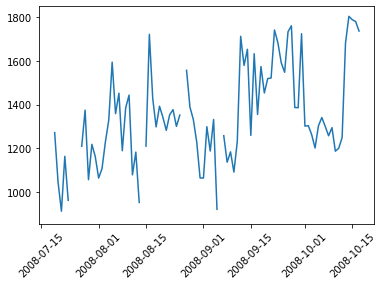

In [31]:
# Plot column 3 by day
plt.plot(byday.index, byday.iloc[:,3])
plt.xticks(rotation=45)

In [16]:
# Plot 3 random days and count how many 0s, 1s
# Pick 3 random days
byday.sample(3)

# Pull all these days from full df (based off of original iteration of 'sample')
begoct = newdf3.loc['2008-10-04']
endaug = newdf3.loc['2008-08-22']
endjul = newdf3.loc['2008-07-20']

Text(0.5, 1.0, 'Counts of satisfactory (0) and faulty (1) diapers on October 4th, 2008')

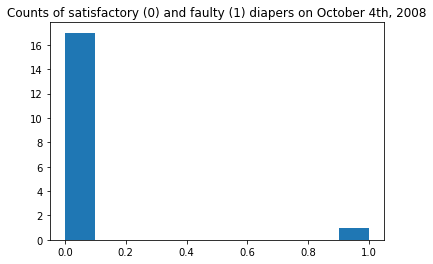

In [17]:
# begoct
plt.hist(begoct['class'])
plt.title('Counts of satisfactory (0) and faulty (1) diapers on October 4th, 2008')

Text(0.5, 1.0, 'Counts of satisfactory (0) and faulty (1) diapers on August 22nd, 2008')

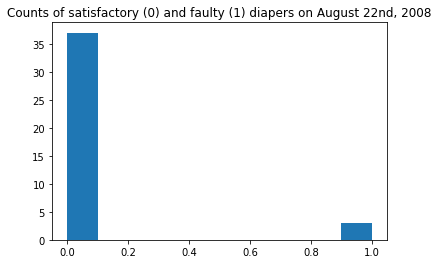

In [18]:
# endaug
plt.hist(endaug['class'])
plt.title('Counts of satisfactory (0) and faulty (1) diapers on August 22nd, 2008')

Text(0.5, 1.0, 'Counts of satisfactory (0) and faulty (1) diapers on July 20th, 2008')

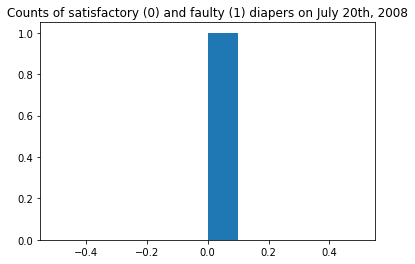

In [19]:
# endjul
plt.hist(endjul['class'])
plt.title('Counts of satisfactory (0) and faulty (1) diapers on July 20th, 2008')

## 5. Handle class imbalance problem

In [20]:
# Establish features
x = newdf3.loc[:, newdf3.columns != 'class']

# Establish target label (variable we are trying to predict)
y = newdf3['class']

In [21]:
# Apply SMOTE for class imbalance
# What did the imbalance look like before SMOTE
print('Original dataset shape {}'.format(Counter(y)))

# Apply SMOTE
sm = SMOTE(random_state = 42)
x_res, y_res = sm.fit_sample(x,y)

# What does the imbalance look like after SMOTE
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 1463, 1: 104})
Resampled dataset shape Counter({0: 1463, 1: 1463})


## 6. Apply feature selection techniques to reduce dimensionality of data

### Recursive Feature Elimination (RFE) / Backward model selection

In [22]:
# Establish model we will be using (linear regression)
estimator = LinearRegression()

# Establish how many features you will select (1 = remove one variable)
selector = RFE(estimator, 5, step=1)

# Fit model to data
selector = selector.fit(x_res, y_res)

# Print the mask of selected features
print(selector.support_)

# Print ranking of features (selected features are ranked 1, 6th is removed first, 2nd is the last removed)
print(selector.ranking_)


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [23]:
# Check data
selector.support_.shape

(590,)

In [24]:
# See which features we would like to keep
np.where(selector.support_ == True)

(array([ 95, 172, 174, 307, 309]),)

### Forward Feature Selection

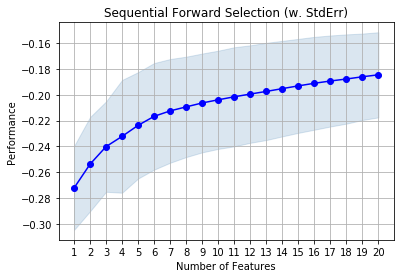

In [25]:
# Forward Stepwise Feature Selection

# Initialize model
lr = LinearRegression()

sfs = SFS(lr, 
          
          # Set how many features we want to examine
          k_features = 20, 
          
          # Establishing our "forward" feature selection
          forward = True,
          floating = False, 
          scoring = 'neg_mean_squared_error',
          cv=  10)

# Fit the model
sfs = sfs.fit(x_res, y_res)
fig = plot_sfs(sfs.get_metric_dict(), kind = 'std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

### LASSO

In [26]:
# LASSO
alpha = 0.5
clf = linear_model.Lasso(alpha=alpha)
clf.fit(x_res, y_res)

print(clf.coef_)

print(clf.intercept_)


[-9.47302083e-05 -1.08254270e-04 -0.00000000e+00 -3.61181486e-05
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.05995129e-04  2.00329891e-05 -4.88553407e-06
 -4.87221729e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.51670013e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  8.82629780e-03
 -0.00000000e+00  0.00000

In [27]:
# Where are the non-zero coefficients
np.where(clf.coef_ != 0)

(array([  0,   1,   3,  21,  22,  23,  24,  51,  59,  67,  88,  90, 137,
        139, 140, 151, 158, 160, 161, 162, 188, 204, 208, 225, 294, 296,
        297, 418, 419, 423, 432, 433, 436, 438, 468, 480, 482, 483, 484,
        485, 486, 487, 488, 489, 499, 500, 510, 511, 521, 570, 572, 581,
        589]),)

### Ridge Regression

In [28]:
# Ridge Regression
alpha = 10 
clf = linear_model.Ridge(alpha = alpha)
clf.fit(x_res, y_res)

print(clf.coef_)

print(clf.intercept_)

import numpy as np
# Increasing alpha can compress the L2 norm of the coefficients to 0 (but not selecting variables)
print("Sum of square of coefficients = %.2f"%np.sum(clf.coef_**2))

[-1.73766903e-04 -1.08654381e-04 -7.06150160e-04 -1.37489314e-04
 -9.67346673e-03  0.00000000e+00 -9.05368052e-03 -3.72450677e-03
 -9.83161991e-02 -2.61174560e-02 -1.85111871e-02  8.86521003e-03
  2.65581036e-02  0.00000000e+00 -1.71586842e-03  1.28850945e-03
  4.84803194e-02  1.09477436e-02 -2.81060027e-02  1.11246393e-02
  4.63971498e-02 -9.29563735e-06 -3.26089666e-04 -2.00145899e-07
 -1.96802695e-06  7.22430499e-02 -7.59593167e-02  3.40840966e-03
 -2.81042640e-03  1.02013747e-03 -7.93548622e-02 -1.96171828e-02
  2.72089256e-02  5.17174732e-03  2.22614257e-03 -1.12789453e-02
 -2.22509370e-03  5.09730028e-03 -4.31244103e-02 -2.18863145e-02
 -1.64287134e-03 -1.62790293e-02  0.00000000e+00  1.62140982e-02
  8.47289044e-02  1.35354855e-02 -4.99679992e-02  4.65769336e-02
 -2.14614259e-03  0.00000000e+00  2.76314022e-02  4.24936426e-04
  0.00000000e+00 -2.57392328e-02 -8.86664873e-02  8.47798043e-04
  2.55608302e-02  1.22842722e-02  2.47408889e-01  2.02057558e-02
 -5.12344335e-03  9.59647

In [29]:
np.where(clf.coef_ != 0)

(array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  43,  44,  45,  46,  47,  48,  50,  51,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
        180, 181, 182, 183, 184, 185, 187, 188, 195

## 7. Describe your initial findings in a summary section
After cleaning and exploring the data, we balanced the classes and applied a few feature selection techniques. Using the *backward model selection* we found 5 features that significantly impacted the model. The forward feature selection took a very long time to run on my computer. I ran it twice, with the last k being 20. I see that the number of valuable features likely increases, however, my computer cannot seem to handle the load that requires (likely stemming form the 500+ original features), this further illustrates the importance of computing power being taken into conosideration when doing machine learning. Using a *LASSO* method, we found a suitable number of features we could use in a model. Comparatively, our *ridge regression* returned a massive amount of features we can use in the model. This makes sense, as the LASSO methood overcomes the disadvantage of ridge regression by punishing high values of the coefficients and setting them to zero if they are noot relevant (i.e more strict).

Overall, I enjoyed running the backward model selection most. It took less computing time than than other approaches for such a large data set and provided a reasonable amount of features to use in models.